In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on, file_mfccs, segments_from_audio_file
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.001

In [2]:
train_ds, val_ds, label_names = dataset_tf("dataset/pt10-sbcm-1024-16_train", 0.30, 16)
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

Found 40 files belonging to 2 classes.
Using 28 files for training.
Using 12 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-28 23:39:20.692871: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-28 23:39:20.692894: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-28 23:39:20.692902: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-28 23:39:20.692943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 23:39:20.692964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
513 44100


In [3]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")

# Train

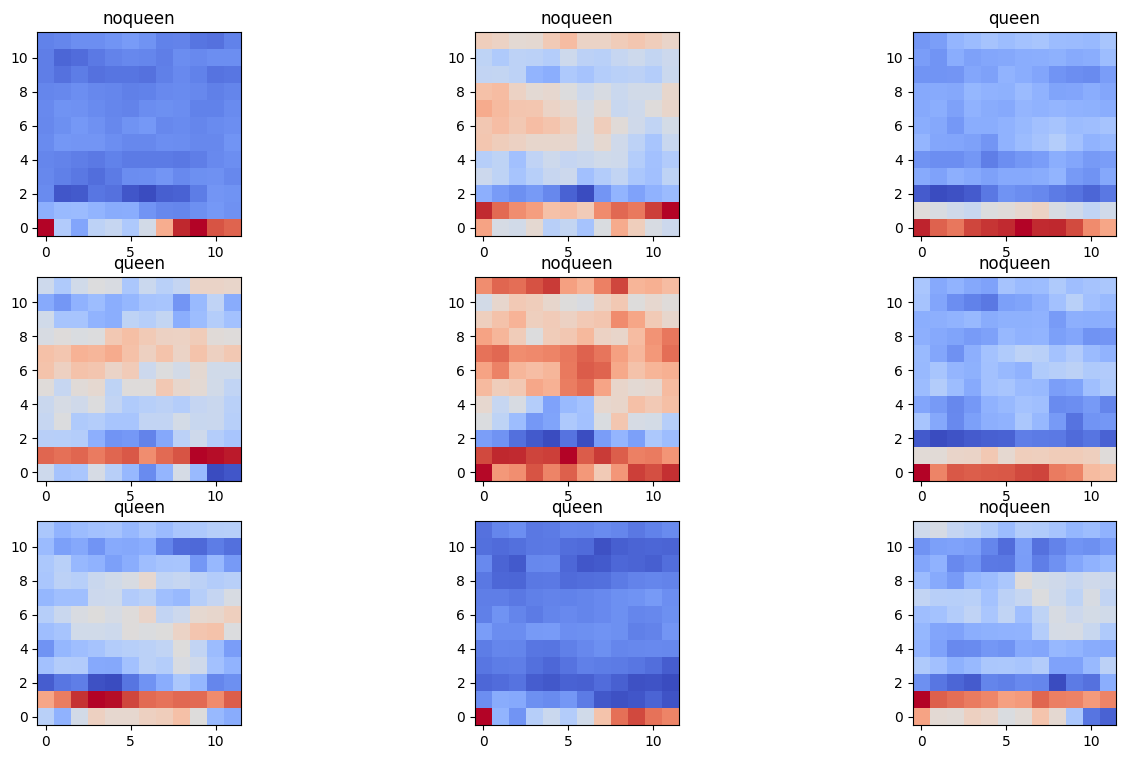

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
print(input_shape)
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

(12, 12, 1)


# EVAL

In [6]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")

2024-03-28 23:39:22.473387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 898ms/step - loss: 4.4910 - accuracy: 0.5000
MFCC Seq: [4.49102258682251, 0.5]
1/1 [==============================] - 0s 215ms/step - loss: 1.5623 - accuracy: 0.5000
MFCC Conv: [1.5622562170028687, 0.5]


## Sequential

Epoch 1/10


2024-03-28 23:39:23.612715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


2/2 [==============================] - 1s 117ms/step - loss: 5.1386 - accuracy: 0.5000 - val_loss: 3.9327 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 23ms/step - loss: 4.2535 - accuracy: 0.5000 - val_loss: 2.9115 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 23ms/step - loss: 2.8319 - accuracy: 0.5000 - val_loss: 1.8483 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 0s 24ms/step - loss: 1.9483 - accuracy: 0.5357 - val_loss: 1.0186 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 0s 24ms/step - loss: 1.2219 - accuracy: 0.5000 - val_loss: 0.8913 - val_accuracy: 0.6667
Epoch 6/10
2/2 [==============================] - 0s 24ms/step - loss: 1.1821 - accuracy: 0.4286 - val_loss: 1.0794 - val_accuracy: 0.5833
Epoch 7/10
2/2 [==============================] - 0s 22ms/step - loss: 1.3116 - accuracy: 0.5000 - val_loss: 1.1860 - val_accuracy: 0.5833
Epoch 8/10
2/2 [=====================

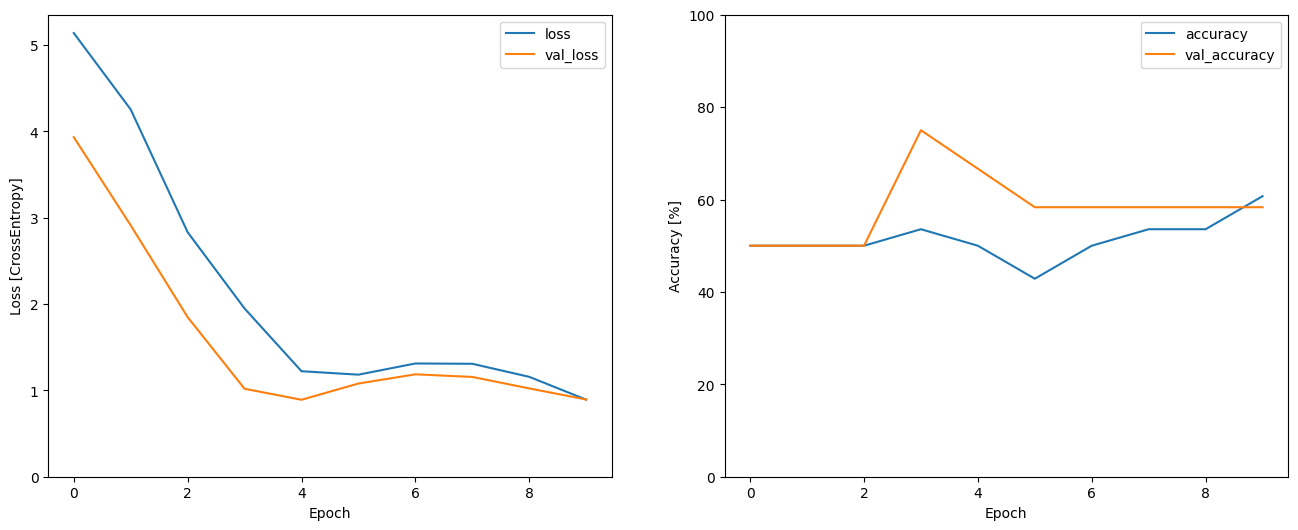

In [7]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

## Convolutional

Epoch 1/10
2/2 [==============================] - 1s 451ms/step - loss: 1.7411 - accuracy: 0.5000 - val_loss: 1.5409 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 14ms/step - loss: 1.6865 - accuracy: 0.5000 - val_loss: 1.4750 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 14ms/step - loss: 1.5921 - accuracy: 0.5000 - val_loss: 1.3791 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 0s 14ms/step - loss: 1.4999 - accuracy: 0.5000 - val_loss: 1.2631 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 0s 13ms/step - loss: 1.3615 - accuracy: 0.5000 - val_loss: 1.1424 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 14ms/step - loss: 1.1838 - accuracy: 0.5000 - val_loss: 1.0278 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 13ms/step - loss: 1.0818 - accuracy: 0.5000 - val_loss: 0.9176 - val_accuracy: 0.5000
Epoch 8/10
2/2 [==========

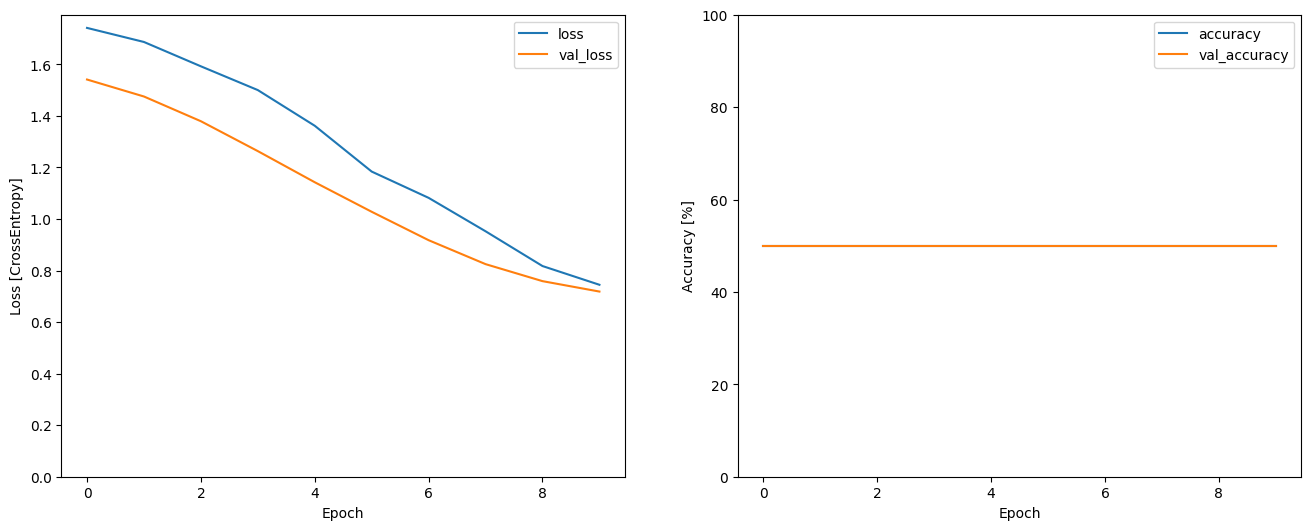

In [8]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

# Summary

In [9]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f},   VL: {history.history['val_loss'][-1]:.2f}, VA: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("Trained MFCCs + Seq ", trained_history_mfcc_seq)
history_to_summary("Trained MFCCs + Conv", trained_history_mfcc_conv)

Trained MFCCs + Seq :    Loss: 0.89, Acc: 0.61,   VL: 0.89, VA: 0.58
Trained MFCCs + Conv:    Loss: 0.74, Acc: 0.50,   VL: 0.72, VA: 0.50
